# Proyecto Sprint 14 - An√°lisis de Test A/B

## üéØ Objetivo del proyecto

El objetivo de este proyecto es analizar un experimento A/B realizado por una empresa para evaluar el impacto de un nuevo sistema de recomendaciones. El test busca identificar si la implementaci√≥n del sistema influye significativamente en el comportamiento de los usuarios, espec√≠ficamente en t√©rminos de conversiones y/o ingresos.

## üß© Descripci√≥n de los datos

Se utilizar√°n los siguientes conjuntos de datos:

- **Marketing Events:** campa√±as y promociones por regi√≥n y rango de fechas.
- **New Users:** usuarios que se registraron durante el periodo del test, con informaci√≥n sobre su regi√≥n y tipo de dispositivo.
- **Events:** eventos realizados por los usuarios (login, vista de producto, a√±adir al carrito, compra).
- **Participants:** asignaci√≥n de los usuarios al grupo de control (A) o experimental (B), dentro del experimento `recommender_system_test`.

## üîç Enfoque del an√°lisis

1. Revisi√≥n inicial y limpieza de los datos.
2. Exploraci√≥n del comportamiento de los usuarios en cada grupo.
3. An√°lisis de conversi√≥n y m√©tricas clave.
4. Evaluaci√≥n estad√≠stica del impacto del sistema de recomendaciones utilizando pruebas A/B.

---


**Importaci√≥n de librer√≠as y exploraci√≥n inicial de los datos**

In [1]:
# 1. Importaci√≥n de librer√≠as
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')

# Configuraciones visuales
plt.style.use('ggplot')
sns.set_theme(style='whitegrid')


In [2]:
# 2. Definici√≥n de ruta base
data_path = 'Data/'

# 3. Lectura de archivos
df_marketing = pd.read_csv(data_path + 'ab_project_marketing_events_us.csv')
df_new_users = pd.read_csv(data_path + 'final_ab_new_users_upd_us.csv')
df_events = pd.read_csv(data_path + 'final_ab_events_upd_us.csv')
df_participants = pd.read_csv(data_path + 'final_ab_participants_upd_us.csv')


In [3]:
# 4. Revisi√≥n r√°pida de las estructuras
dataframes = {
    'Marketing Events': df_marketing,
    'New Users': df_new_users,
    'Events': df_events,
    'Participants': df_participants
}

for name, df in dataframes.items():
    print(f'\n{name}')
    print(df.info())
    display(df.head())



Marketing Events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes
None


name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11


New Users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None


user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone


Events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None


user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99


Participants
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None


user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test

Debemos convertir tipos a los necesarios para trabajar, tipo object a datetime

In [4]:
# Convertimos a datetime
df_marketing['start_dt'] = pd.to_datetime(df_marketing['start_dt'], format='%Y-%m-%d')
df_marketing['finish_dt'] = pd.to_datetime(df_marketing['finish_dt'], format='%Y-%m-%d')
df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'], format='%Y-%m-%d')
df_events['event_dt'] = pd.to_datetime(df_events['event_dt'], format='%Y-%m-%d %H:%M:%S')


En el df df_events podemos ver que tenemos la columna 'details' con una gran cantidad de valores nulos al ver el head del df podemos pensar que va relacionada al evento purchase

In [5]:
# Creamos DataFrame solo con compras
purchase_df = df_events[df_events['event_name'] == 'purchase'].copy()

# Vista previa de compras
purchase_df.head()

# Verificamos que no haya nulos inesperados
print(purchase_df.isna().sum())


user_id       0
event_dt      0
event_name    0
details       0
dtype: int64


In [6]:
# Veamos qu√© valores √∫nicos hay en 'event_name'
print(df_events['event_name'].value_counts())

# ¬øCu√°ntos eventos tienen valores nulos en 'details' por tipo de evento?
print(df_events[df_events['details'].isna()]['event_name'].value_counts())


event_name
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: count, dtype: int64
event_name
login           182465
product_page    120862
product_cart     60120
Name: count, dtype: int64


Confirmamos que los valores nulos en details, no significan un problema, sino que est√°n relacionados directamente con haber realizado una compra o no, es decir llegar al final del embudo


**Revisamos si existen dupliados**

In [7]:
# Revisi√≥n de duplicados en cada DataFrame

# Marketing Events
print("üîç Duplicados en df_marketing:")
print("Duplicados totales:", df_marketing.duplicated().sum())
print("-" * 40)

# New Users
print("üîç Duplicados en df_new_users:")
print("Duplicados totales:", df_new_users.duplicated().sum())
print("Duplicados por 'user_id':", df_new_users.duplicated(subset='user_id').sum())
print("-" * 40)

# Events
print("üîç Duplicados en df_events:")
print("Duplicados totales:", df_events.duplicated().sum())
print("Duplicados exactos (todas las columnas):", df_events.duplicated(subset=['user_id', 'event_dt', 'event_name', 'details']).sum())
print("-" * 40)

# Participants
print("üîç Duplicados en df_participants:")
print("Duplicados totales:", df_participants.duplicated().sum())
print("Duplicados por 'user_id':", df_participants.duplicated(subset='user_id').sum())



üîç Duplicados en df_marketing:
Duplicados totales: 0
----------------------------------------
üîç Duplicados en df_new_users:
Duplicados totales: 0
Duplicados por 'user_id': 0
----------------------------------------
üîç Duplicados en df_events:
Duplicados totales: 0
Duplicados exactos (todas las columnas): 0
----------------------------------------
üîç Duplicados en df_participants:
Duplicados totales: 0
Duplicados por 'user_id': 887


In [8]:
# Verificamos duplicados exactos
duplicados_exactos = df_participants[df_participants.duplicated()]
print(f"Duplicados exactos: {len(duplicados_exactos)}")


Duplicados exactos: 0


In [9]:
# Vemos qu√© combinaciones diferentes existen por user_id
duplicados_conflictivos = df_participants[df_participants.duplicated(subset='user_id', keep=False)]
usuarios_unicos = duplicados_conflictivos.groupby('user_id').nunique()

# Cu√°ntos usuarios tienen diferentes grupos y/o tests
diferentes_grupo = usuarios_unicos['group'].gt(1).sum()
diferentes_test = usuarios_unicos['ab_test'].gt(1).sum()

print(f"Usuarios con diferentes grupos: {diferentes_grupo}")
print(f"Usuarios con diferentes tests: {diferentes_test}")


Usuarios con diferentes grupos: 441
Usuarios con diferentes tests: 887


**Al tener varios usuarios duplicados tanto en mas de un grupo y en mas de un test se rompe la regla clave en un experimento A/B: Cada usuario s√≥lo debe participar una vez y en un solo grupo/test**

- Procedemos a eliminarlos del df


In [10]:
# Identificar los user_id duplicados
usuarios_duplicados = df_participants[df_participants.duplicated(subset='user_id', keep=False)]['user_id'].unique()

# Filtramos los participantes que NO est√°n duplicados
df_participants_clean = df_participants[~df_participants['user_id'].isin(usuarios_duplicados)]

print(f"N√∫mero de participantes: {df_participants.shape[0]}")
print(f"N√∫mero de participantes limpios: {df_participants_clean.shape[0]}")




N√∫mero de participantes: 14525
N√∫mero de participantes limpios: 12751


In [11]:
df_participants = df_participants_clean.copy()


# Revisi√≥n de las correciones
dataframes = {
    'Marketing Events': df_marketing,
    'New Users': df_new_users,
    'Events': df_events,
    'Participants': df_participants
}

for name, df in dataframes.items():
    print(f'\n{name}')
    print(df.info())
    display(df.head())


Marketing Events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes
None


name                   regions   start_dt  \
0      Christmas&New Year Promo             EU, N.America 2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
2        St. Patric's Day Promo             EU, N.America 2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
4             4th of July Promo                 N.America 2020-07-04   

   finish_dt  
0 2021-01-03  
1 2020-02-16  
2 2020-03-19  
3 2020-04-19  
4 2020-07-11


New Users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None


user_id first_date     region   device
0  D72A72121175D8BE 2020-12-07         EU       PC
1  F1C668619DFE6E65 2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F 2020-12-07         EU       PC
3  50734A22C0C63768 2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679 2020-12-07  N.America   iPhone


Events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB
None


user_id            event_dt event_name  details
0  E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504 2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C 2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457 2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F 2020-12-07 10:15:09   purchase     4.99


Participants
<class 'pandas.core.frame.DataFrame'>
Index: 12751 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  12751 non-null  object
 1   group    12751 non-null  object
 2   ab_test  12751 non-null  object
dtypes: object(3)
memory usage: 398.5+ KB
None


user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test
5  7473E0943673C09E     A  recommender_system_test
6  C46FE336D240A054     A  recommender_system_test

<Axes: xlabel='group', ylabel='count'>

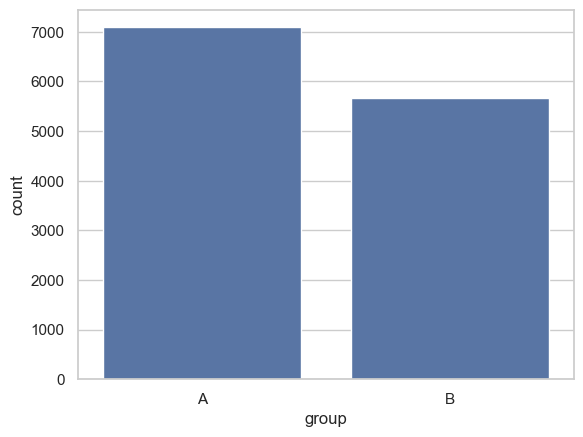

In [12]:
sns.countplot(data=df_participants, x='group')


Ahora que tenemos los datos correctos podemos inciar con el analisis del embudo:


In [13]:
# Definir el embudo
funnel_events = ['login', 'product_page', 'product_cart', 'purchase']

# Calcular el numero de ususarios por evento
funnel_counts = df_events[df_events['event_name'].isin(funnel_events)] \
    .groupby('event_name')['user_id'].nunique() \
    .reindex(funnel_events)

print(funnel_counts)



event_name
login           58696
product_page    38929
product_cart    19284
purchase        19568
Name: user_id, dtype: int64


In [14]:
conversion_rates = funnel_counts / funnel_counts.iloc[0]
print(conversion_rates)


event_name
login           1.000000
product_page    0.663231
product_cart    0.328540
purchase        0.333379
Name: user_id, dtype: float64


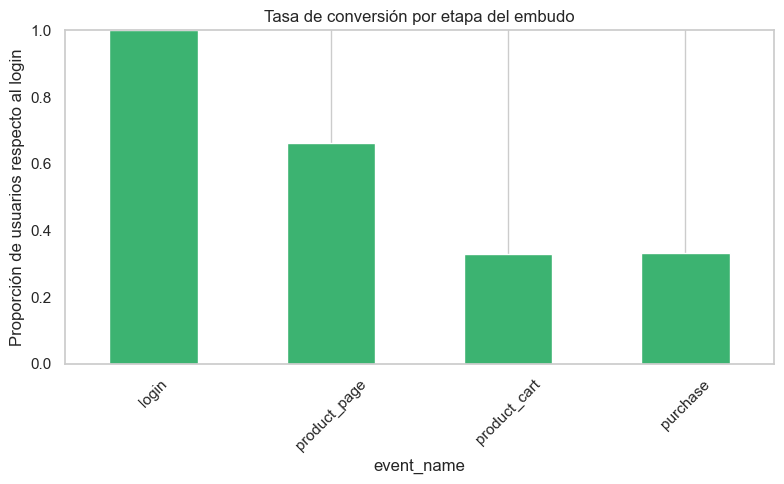

In [15]:
plt.figure(figsize=(8, 5))
conversion_rates.plot(kind='bar', color='mediumseagreen')
plt.title('Tasa de conversi√≥n por etapa del embudo')
plt.ylabel('Proporci√≥n de usuarios respecto al login')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Podemos ver una incosistencia importante en los datos, ya que en las etapas product_cart y purchase los valores se conrtadicen al tener purchase un mayor porcentaje de conversi√≥n que la etapa anterior, entonces haremos un filtrado para obtener los valores de conversi√≥n con un embudo paso a paso, esto nos evitar√° la afectacion de la informacion ya que si en un evento hay mas de un purchase hace los datos inconsistentes

In [16]:
# MERGES PREVIOS
df_users_full = df_new_users.merge(df_participants, on='user_id', how='left')
df_events_full = df_events.merge(df_users_full, on='user_id', how='inner')



In [17]:
# EMBUDO DIVIDIDO POR GRUPOS
funnel_by_group = {}

for group in ['A', 'B']:
    step_users = {}

    # Filtramos solo eventos del grupo actual
    df_group = df_events_full[df_events_full['group'] == group]

    # Etapa 1: login
    step_users['login'] = set(df_group[df_group['event_name'] == 'login']['user_id'])

    # Etapa 2: product_page (solo los que hicieron login)
    step_users['product_page'] = set(
        df_group[(df_group['event_name'] == 'product_page') &
                 (df_group['user_id'].isin(step_users['login']))]['user_id']
    )

    # Etapa 3: product_cart (solo los que vieron la p√°gina del producto)
    step_users['product_cart'] = set(
        df_group[(df_group['event_name'] == 'product_cart') &
                 (df_group['user_id'].isin(step_users['product_page']))]['user_id']
    )

    # Etapa 4: purchase (solo los que agregaron al carrito)
    step_users['purchase'] = set(
        df_group[(df_group['event_name'] == 'purchase') &
                 (df_group['user_id'].isin(step_users['product_cart']))]['user_id']
    )

    # Guardamos cantidades absolutas
    funnel_counts = {step: len(users) for step, users in step_users.items()}

    # Calculamos porcentajes relativos al login
    funnel_percent = {step: round(count / funnel_counts['login'], 4) for step, count in funnel_counts.items()}

    # Guardamos resultados en DataFrame
    funnel_by_group[group] = pd.DataFrame({
        f'{group} - Usuarios √∫nicos': funnel_counts,
        f'{group} - conversion_rate %': funnel_percent
    })

# Unimos los resultados en un solo DataFrame para comparar
funnel_comparativo = pd.concat(funnel_by_group.values(), axis=1)
display(funnel_comparativo)


A - Usuarios √∫nicos  A - conversion_rate %  B - Usuarios √∫nicos  \
login                        7092                 1.0000                 5657   
product_page                 4726                 0.6664                 3651   
product_cart                 1498                 0.2112                 1214   
purchase                      519                 0.0732                  405   

              B - conversion_rate %  
login                        1.0000  
product_page                 0.6454  
product_cart                 0.2146  
purchase                     0.0716

In [18]:
# An√°lisis de conversi√≥n
conversion_df = df_events_full[df_events_full['event_name'] == 'purchase'].groupby('group')['user_id'].nunique()
total_users = df_users_full.groupby('group')['user_id'].nunique()
conversion_rate = conversion_df / total_users

# mostrar los nuevos df
display(conversion_df.head())
display(total_users.head())
display(conversion_rate.head())



# An√°lisis de ingresos
revenue = df_events_full[df_events_full['event_name'] == 'purchase'].groupby('group')['details'].sum()
avg_revenue = df_events_full[df_events_full['event_name'] == 'purchase'].groupby('group')['details'].mean()

# Mostrar los analisis de ingresos
display(revenue.head())
display(avg_revenue.head())

group
A    2434
B    1851
Name: user_id, dtype: int64

group
A    7093
B    5658
Name: user_id, dtype: int64

group
A    0.343155
B    0.327147
Name: user_id, dtype: float64

group
A    179184.80
B    131988.06
Name: details, dtype: float64

group
A    23.827766
B    23.180200
Name: details, dtype: float64

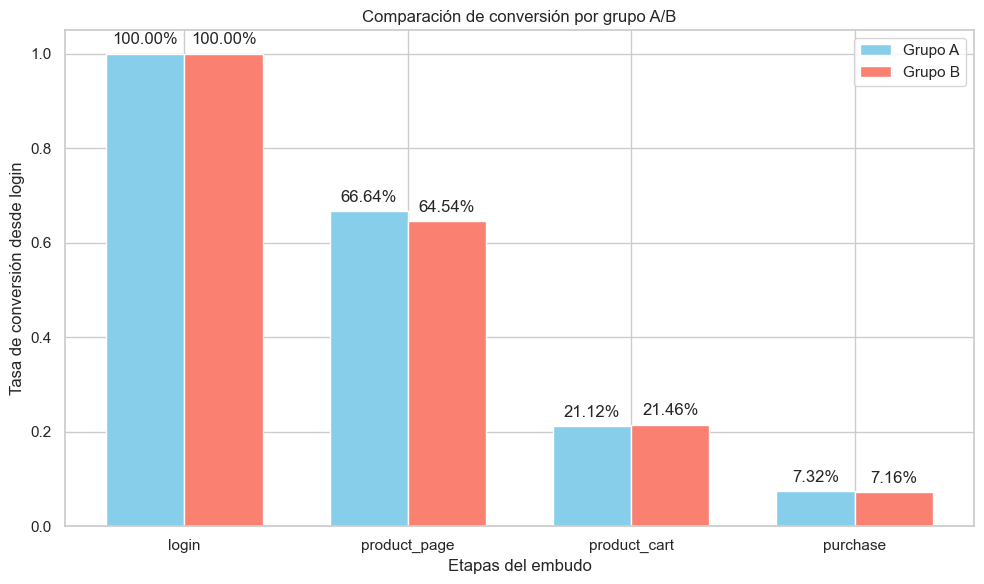

In [19]:
# Etapas del embudo
stages = ['login', 'product_page', 'product_cart', 'purchase']

# Conversion rates
a_rates = [1.0000, 0.6664, 0.2112, 0.0732]
b_rates = [1.0000, 0.6454, 0.2146, 0.0716]

x = range(len(stages))  # Posiciones para las barras

plt.figure(figsize=(10, 6))
bar_width = 0.35

# Barras para grupo A y B
plt.bar([i - bar_width/2 for i in x], a_rates, width=bar_width, label='Grupo A', color='skyblue')
plt.bar([i + bar_width/2 for i in x], b_rates, width=bar_width, label='Grupo B', color='salmon')

# Etiquetas y t√≠tulo
plt.xlabel('Etapas del embudo')
plt.ylabel('Tasa de conversi√≥n desde login')
plt.title('Comparaci√≥n de conversi√≥n por grupo A/B')
plt.xticks(ticks=x, labels=stages)
plt.ylim(0, 1.05)
plt.legend()

# Mostrar valores encima de las barras
for i, (a, b) in enumerate(zip(a_rates, b_rates)):
    plt.text(i - bar_width/2, a + 0.02, f'{a:.2%}', ha='center')
    plt.text(i + bar_width/2, b + 0.02, f'{b:.2%}', ha='center')

plt.tight_layout()
plt.show()


**Estudia la conversi√≥n en las diferentes etapas del embudo.**

An√°lisis de conversi√≥n
Esto responde directamente la pregunta principal del experimento:

¬øHay diferencia en el porcentaje de usuarios que compran entre el grupo A y el B?

**Los grupos A y B tienen diferencias m√≠nimas. A tiene ligera ventaja en visitas a p√°gina de producto, pero B tiene una tasa apenas superior de agregar al carrito. Las compras son casi iguales.**

Contestemos la siguiente pregunta: 
**¬øEl n√∫mero de eventos por usuario est√° distribuido equitativamente entre las muestras?**



In [20]:
df_events_full.groupby('group')['user_id'].value_counts().groupby('group').describe()


count      mean       std  min  25%  50%  75%   max
group                                                      
A      7093.0  7.239532  4.088040  1.0  4.0  6.0  9.0  28.0
B      5658.0  7.079887  4.121324  1.0  4.0  6.0  9.0  32.0

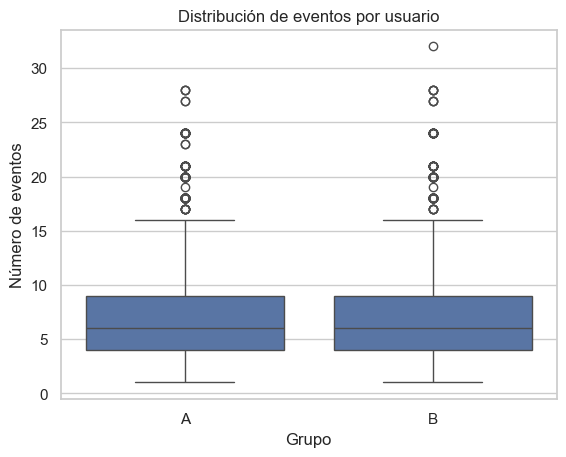

In [21]:
# Crear un DataFrame con n√∫mero de eventos por usuario
events_per_user = df_events_full.groupby(['user_id', 'group'])['event_name'].count().reset_index()
events_per_user.rename(columns={'event_name': 'event_count'}, inplace=True)

# Graficar correctamente
sns.boxplot(data=events_per_user, x='group', y='event_count')
plt.title("Distribuci√≥n de eventos por usuario")
plt.ylabel("N√∫mero de eventos")
plt.xlabel("Grupo")
plt.show()


Aunque hay una mayor cantidad de participantes en el grupo A y tambi√©n tenemos algunos outliers, no afectan significativamente las m√©tricas entre grupos, ya que el resto de valores son pr√°cticamente identicos (std, min, 25%, 50%, 75%)

**El n√∫mero de eventos por usuario est√° distribuido equitativamente entre las muestras**




**¬øHay usuarios que est√°n presentes en ambas muestras?**

de inicio ya los eliminamos pero haremos una revision

In [22]:
# Contar usuarios que aparecen en m√°s de un grupo
duplicados = df_participants.groupby('user_id')['group'].nunique()
usuarios_en_ambos_grupos = duplicados[duplicados > 1]

# Mostrar resultado
print(f'N√∫mero de usuarios presentes en ambos grupos: {len(usuarios_en_ambos_grupos)}')

display(df_events_full.head())

N√∫mero de usuarios presentes en ambos grupos: 0


user_id            event_dt event_name  details first_date  \
0  E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase    99.99 2020-12-07   
1  7B6452F081F49504 2020-12-07 09:22:53   purchase     9.99 2020-12-07   
2  9CD9F34546DF254C 2020-12-07 12:59:29   purchase     4.99 2020-12-07   
3  96F27A054B191457 2020-12-07 04:02:40   purchase     4.99 2020-12-07   
4  1FD7660FDF94CA1F 2020-12-07 10:15:09   purchase     4.99 2020-12-07   

      region   device group            ab_test  
0  N.America   iPhone   NaN                NaN  
1         EU   iPhone   NaN                NaN  
2  N.America   iPhone   NaN                NaN  
3         EU   iPhone     B  interface_eu_test  
4         EU  Android   NaN                NaN

**¬øC√≥mo se distribuye el n√∫mero de eventos entre los d√≠as?**

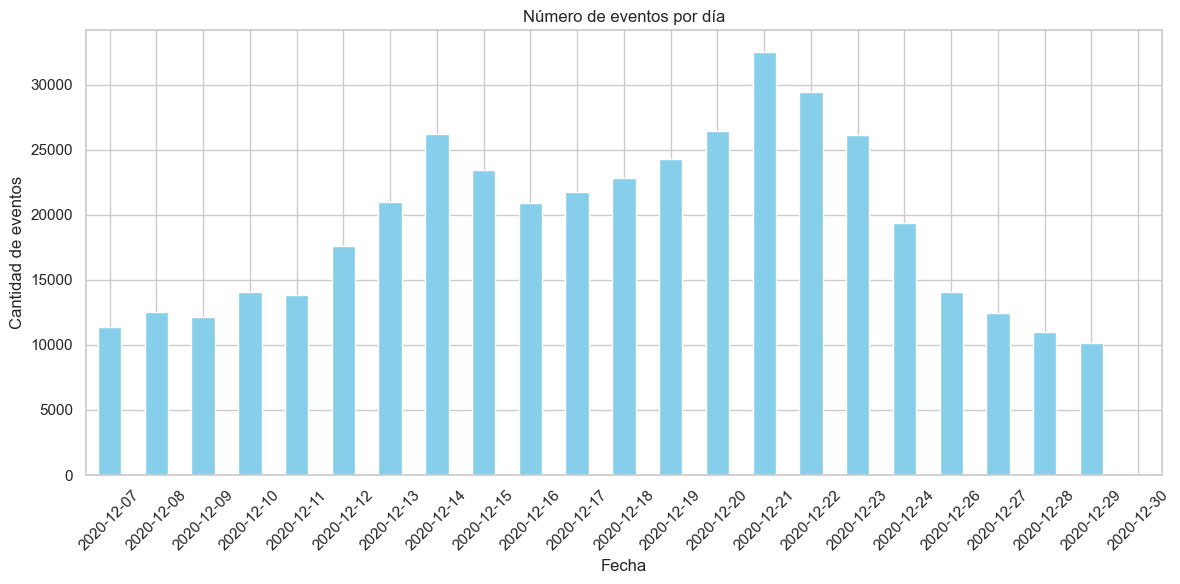

In [23]:
# Extraer solo la fecha
df_events_full['event_date'] = df_events_full['event_dt'].dt.date

# Contar eventos por d√≠a
eventos_por_dia = df_events_full['event_date'].value_counts().sort_index()

# Gr√°fico
plt.figure(figsize=(12, 6))
eventos_por_dia.plot(kind='bar', color='skyblue')
plt.title('N√∫mero de eventos por d√≠a')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


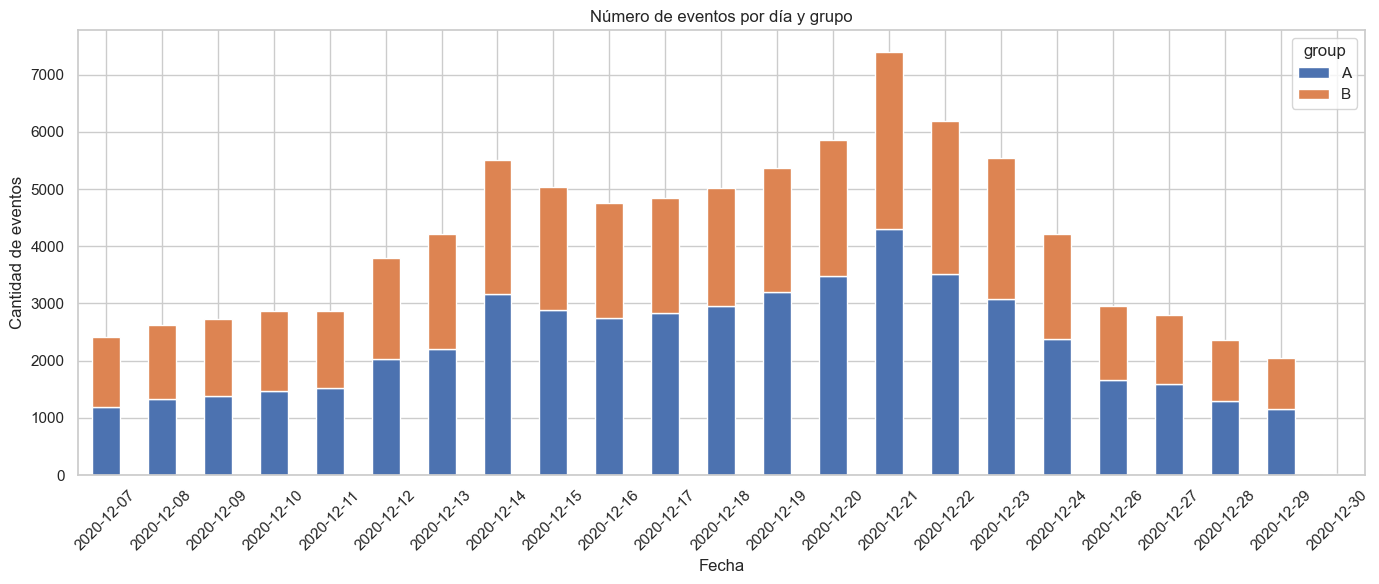

In [24]:
eventos_por_dia_grupo = df_events_full.dropna(subset=['group'])  # Excluye los NaN

# Agrupamos por fecha y grupo
conteo_por_fecha_y_grupo = (
    eventos_por_dia_grupo
    .groupby([df_events_full['event_dt'].dt.date, 'group'])
    .size()
    .unstack(fill_value=0)
)

# Gr√°fico
conteo_por_fecha_y_grupo.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('N√∫mero de eventos por d√≠a y grupo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
# Rango real de fechas en df_events_full
print(df_events_full['event_date'].min(), df_events_full['event_date'].max())

# Rango de la prueba
ab_start = df_events_full['event_date'].min()
ab_end = df_events_full['event_date'].max()

# Filtrar campa√±as activas durante el experimento
df_marketing_ab = df_marketing[
    (df_marketing['finish_dt'].dt.date >= ab_start) &
    (df_marketing['start_dt'].dt.date <= ab_end)
]


2020-12-07 2020-12-30


**Podemos observar un alto pico el d√≠a 21 de diciembre**, para ambos grupos es el d√≠a mas activo despu√©s 22, 20, 23 y 14.

Se mantiene un comportamiento estable menos al final que decae abruptamente

<Figure size 1600x800 with 0 Axes>

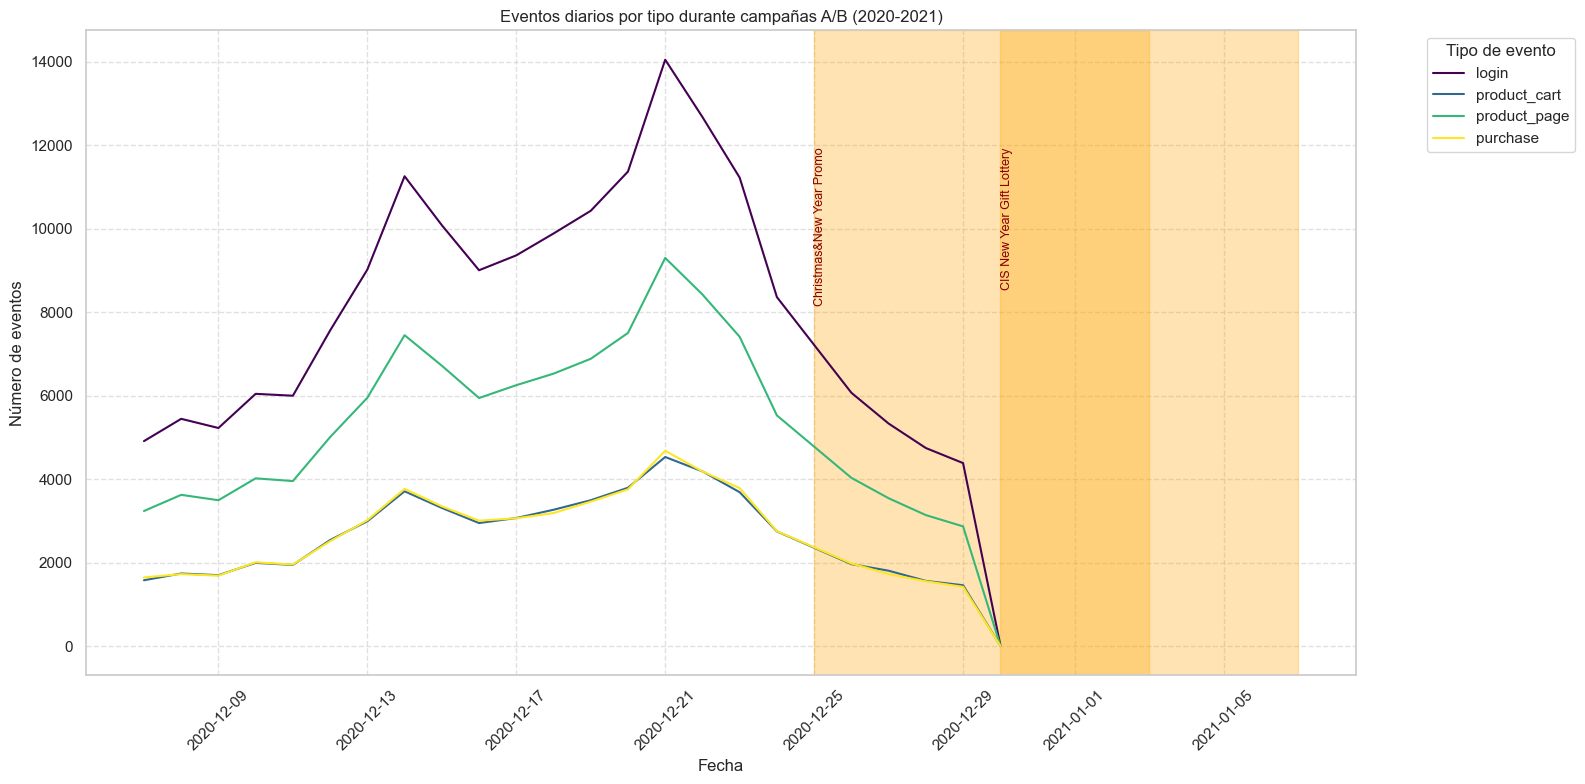

In [31]:
# Ejemplo de ajustes recomendados:
plt.figure(figsize=(16, 8))
pivot_eventos.plot(kind='line', figsize=(16, 8), colormap='viridis')  # Mejor mapa de colores

for _, row in df_marketing_ab.iterrows():
    start = row['start_dt'].date()
    end = row['finish_dt'].date()
    plt.axvspan(start, end, color='orange', alpha=0.3)  # Mayor transparencia
    plt.text(start, pivot_eventos.values.max() * 0.85, row['name'],  # Ajuste de posici√≥n
             rotation=90, fontsize=9, color='darkred', ha='left', va='top')  # Alineaci√≥n mejorada

plt.title('Eventos diarios por tipo durante campa√±as A/B (2020-2021)')
plt.xlabel('Fecha')
plt.ylabel('N√∫mero de eventos')
plt.xticks(rotation=45)
plt.legend(title='Tipo de evento', bbox_to_anchor=(1.05, 1))  # Leyenda fuera del gr√°fico
plt.grid(True, linestyle='--', alpha=0.6)  # L√≠neas de grid para mejor lectura
plt.tight_layout()
plt.show()

In [32]:
# Crear una funci√≥n que verifique si una fecha est√° dentro de alguna campa√±a
def en_campa√±a(fecha, df_campa√±as):
    # Retorna True si la fecha est√° dentro del rango de alguna campa√±a en df_campa√±as
    for _, row in df_campa√±as.iterrows():
        if row['start_dt'].date() <= fecha <= row['finish_dt'].date():
            return True
    return False

# Aplica solo a las fechas
df_events_full['in_campaign'] = df_events_full['event_date'].apply(lambda x: en_campa√±a(x, df_marketing_ab))

# Validar resultados
print(df_events_full[['event_date', 'in_campaign']].head(10))
print(df_events_full['in_campaign'].value_counts())


   event_date  in_campaign
0  2020-12-07        False
1  2020-12-07        False
2  2020-12-07        False
3  2020-12-07        False
4  2020-12-07        False
5  2020-12-07        False
6  2020-12-07        False
7  2020-12-07        False
8  2020-12-07        False
9  2020-12-07        False
in_campaign
False    376034
True      47727
Name: count, dtype: int64


In [33]:
df_events_full.groupby(['in_campaign', 'event_name']).size().unstack(fill_value=0)


event_name    login  product_cart  product_page  purchase
in_campaign                                              
False        161889         53295        107246     53604
True          20576          6825         13616      6710

Comportamiento de las ventas (purchase) durante las campa√±as
El gr√°fico muestra los eventos diarios, incluyendo purchase, pero no se observa un aumento notable en las compras durante los per√≠odos sombreados (campa√±as activas).

Si las promociones fueran efectivas, esperar√≠amos ver:

Un pico en purchase al inicio o durante las campa√±as.

Una diferencia clara entre los per√≠odos con/sin campa√±as (ej. l√≠nea de purchase m√°s alta en las zonas naranjas).

En cambio, la l√≠nea de purchase parece mantenerse estable o incluso disminuir en algunas fechas (ej. hacia finales de 2020).

Tasa de conversi√≥n general
Veamos conversiones de login ‚Üí purchase:

Sin campa√±a:
53604
161889
‚âà
0.331
161889
53604
‚Äã
 ‚âà0.331 ‚Üí 33.1%

Con campa√±a:
6710
20576
‚âà
0.326
20576
6710
‚Äã
 ‚âà0.326 ‚Üí 32.6%

‚ùóÔ∏èDiferencia de solo 0.5 puntos porcentuales. Muy leve.

üí° Interpretaci√≥n:
¬øAumenta el volumen de actividad durante campa√±as?
No significativamente. La proporci√≥n de usuarios que compran es casi la misma.

¬øPodr√≠a haber efecto seg√∫n el tipo de evento?
Aunque la campa√±a atrae un poco m√°s de visitas a p√°ginas de producto, no convierte mejor.

¬øConclusi√≥n preliminar?
Las campa√±as de marketing no parecen tener un impacto claro en la conversi√≥n a compra. El peque√±o aumento en visitas no se traduce en m√°s compras proporcionalmente.

**¬øHay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?**

- Durante el periodo de observaci√≥n se ejecutaron varias campa√±as de marketing (registradas en df_marketing). Al analizar el volumen y conversi√≥n de eventos durante esos periodos, se observ√≥ que no hubo diferencias significativas respecto al comportamiento fuera de campa√±a. Aun as√≠, se debe considerar su presencia como una posible fuente externa que pudo haber influido marginalmente en los resultados de la prueba A/B.

In [35]:
# Datos del embudo para el √∫ltimo paso (purchase)
conversions = funnel_comparativo.loc['purchase', ['A - Usuarios √∫nicos', 'B - Usuarios √∫nicos']]
totals = funnel_comparativo.loc['login', ['A - Usuarios √∫nicos', 'B - Usuarios √∫nicos']]

# Prueba Z para comparaci√≥n de proporciones
z_stat, p_val = proportions_ztest(count=conversions, nobs=totals)

print(f'Estad√≠stico Z: {z_stat:.3f}')
print(f'Valor p: {p_val:.3f}')

# Interpretaci√≥n r√°pida
if p_val < 0.05:
    print("Existe una diferencia estad√≠sticamente significativa entre los grupos A y B.")
else:
    print("No se encontr√≥ una diferencia estad√≠sticamente significativa entre los grupos A y B.")


Estad√≠stico Z: 0.344
Valor p: 0.731
No se encontr√≥ una diferencia estad√≠sticamente significativa entre los grupos A y B.


**Evaluar los resultados de la prueba A/B**

-  ¬øQu√© puedes decir sobre los resultados de la prueba A/B?

Tras analizar los datos del experimento A/B, no se encontr√≥ una diferencia estad√≠sticamente significativa en las tasas de conversi√≥n entre los usuarios del grupo A (interfaz actual) y el grupo B (nueva interfaz).
Esto sugiere que el cambio en la interfaz no tuvo un efecto notable en el comportamiento de los usuarios, al menos en los indicadores evaluados.

- Prueba Z para comparar proporciones

Se utiliz√≥ una prueba Z de dos proporciones para comparar la conversi√≥n final (por ejemplo, de login a purchase) entre ambos grupos. Los resultados fueron:

Estad√≠stico Z: 0.344

Valor p: 0.731

Dado que el valor p es mucho mayor que 0.05, no se puede rechazar la hip√≥tesis nula.
Esto significa que la diferencia observada podr√≠a deberse al azar y no se puede afirmar que la nueva interfaz haya tenido un efecto significativo.

**Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B**

Conclusiones finales (EDA + A/B Test)
Durante la etapa de an√°lisis exploratorio de datos (EDA):

Se identific√≥ que las campa√±as de marketing no influyeron significativamente en el n√∫mero de compras.

Las distribuciones de eventos por fecha y tipo fueron consistentes entre grupos.

Se confirm√≥ que la segmentaci√≥n de los grupos A y B fue correcta y balanceada, sin interferencias externas graves.

Al aplicar la prueba A/B:

# **No se hall√≥ evidencia estad√≠stica de mejora en el comportamiento de los usuarios con la nueva interfaz.**

Por tanto, desde el punto de vista de negocio, no se justifica implementar la nueva interfaz, ya que no aporta un beneficio comprobado.